If runnning code in colab, use Chrome

In [34]:
import copy
import logging
import random
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sm
from sklearn.metrics import f1_score
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from tqdm import tqdm
from tqdm.notebook import tqdm

import torch.utils.tensorboard
from torch.utils.tensorboard import SummaryWriter

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"
torch.manual_seed(8675309)
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [35]:
# Load datasets from torchvision datasets
train=torchvision.datasets.MNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test=torchvision.datasets.MNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [36]:
class PrepareData:
    def __init__(self, train_set, test_set, prop_keep):
        """
        Arguments:
            train_set (torch dataset object)
            test_set (torch dataset object):
        Subsets data to select only desired classes, then imbalances training set, then refactors labels.
        Returns 4 float tensors
        """
        self.train_data, self.train_targets = self.prepare_imbalanced_dataset(train_set, prop_keep)
        self.test_data, self.test_targets = self.prepare_test_dataset(test_set)

    def prepare_test_dataset(self, dataset):
        data, targets = dataset.data, dataset.targets
        data, targets = self.subset_data(data, targets)
        targets = self.refactor_labels(targets)
        return data.float(), targets.float()

    def prepare_imbalanced_dataset(self, dataset, prop_keep):
        data, targets = dataset.data, dataset.targets
        data, targets = self.subset_data(data, targets)
        data, targets = self.imbalance_data(data, targets, prop_keep)
        targets = self.refactor_labels(targets)
        return data.float(), targets.float()

    def subset_data(self, data, targets):
        selection = torch.logical_or(targets == 2, targets == 7)
        data = data[selection]
        targets = targets[selection]
        return data, targets

    def imbalance_data(self, data, targets, prop_keep):
        sample_probs = {'2': (1 - prop_keep), '7': 0}
        idx_to_del = [i for i, label in enumerate(targets) if random.random() > sample_probs[str(label.item())]]
        data = data[idx_to_del]
        targets = targets[idx_to_del].type(torch.float)
        return data, targets

    def refactor_labels(self, targets):
        targets[targets == 2.] = 0
        targets[targets == 7.] = 1
        return targets


In [37]:
# Modify the data
data_preparer = PrepareData(train, test, 0.1)
train.data = data_preparer.train_data
train.targets = data_preparer.train_targets
test.data = data_preparer.test_data
test.targets = data_preparer.test_targets

In [38]:
# SMOTE implemented w/sklearn package
import torch.utils.data as data_utils
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset
print(train.data.shape)
smote = SMOTE()
X, y = smote.fit_resample(train.data.view(len(train), -1), train.targets) # smote the dataset (must flatten to 2d first)

X = np.reshape(X, (len(X), 28, 28)) # reshape X to 3d

X_tensor = torch.from_numpy(X).view(len(X), 28, 28).float() #.to(device) # push X to GPU and reshape
y_tensor = torch.from_numpy(y)  #.to(device)



train.data = X_tensor
train.targets = y_tensor



torch.Size([6833, 28, 28])


In [39]:
torch.unique(train.targets, return_counts=True)
torch.unique(test.targets, return_counts=True)

(tensor([0., 1.]), tensor([1032, 1028]))

In [40]:
# Define simple CNN to classify dataset examples
class NetSMOTE(nn.Module):
    def __init__(self):
        super(NetSMOTE, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [41]:
# configs
configs = {
'n_epochs' : 20, 
'batch_size_train' : 128, 
'batch_size_test' : 500, 
'learning_rate' : 0.01, 
'momentum' : 0.5, 
'log_interval' : 10,
'class_labels' : np.array([2,7])
}
torch.backends.cudnn.enabled = False
#device = 'cuda'

In [42]:
# Define train loader and test loader
train_loader = torch.utils.data.DataLoader(train, batch_size=configs['batch_size_train'], shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=configs['batch_size_test'], shuffle=True)

# Define loss function
loss_fn = nn.CrossEntropyLoss()


In [43]:
def vis(train_loss, test_accs, confusion_mtxes, labels, figsize=(7, 5)):
    cm = confusion_mtxes[np.argmax(test_accs)] # select the best run (highest test accuracy); cm is the array of raw counts for confusion matrix
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100 # cm_perc is the values for the confusion matrix
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%' % p
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_df.index.name = 'Actual'
    cm_df.columns.name = 'Predicted'

    fig = plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.semilogy(train_loss, 'r')
    plt.ylabel('Log training loss')

    plt.subplot(1, 3, 2)
    plt.title('Test Accuracy (%)')
    plt.xlabel('Epoch')
    plt.ylabel('% accurate')
    plt.plot(test_accs, 'g')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.title('Confusion Matrix')
    sns.heatmap(cm_df, annot=annot, fmt='', cmap="Blues")
    plt.show()
    return fig

In [44]:
model = NetSMOTE() #.to(device) # creating an instance of Net() and pushing it to GPU
optimizer = torch.optim.SGD(model.parameters(), configs['learning_rate'], configs['momentum']) # (optimizer args specified in configs)
 
train_loss = []
auroc_list, precision_list, recall_list = [], [], []
pr_curve = torchmetrics.PrecisionRecallCurve(pos_label=1, task = 'binary')
auroc_metric = torchmetrics.classification.BinaryAUROC(thresholds=None)
test_accs, confusion_mtxes = [], []
for epoch in range(1, configs['n_epochs']):
    model.train()
    logging.info(f"Starting epoch {epoch}:")
    pbar = tqdm(train_loader, position=0, leave=True)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data, target # since I'm using CPU, I do not push these tensors to device 
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(CE=loss.item())

    model.eval()
    num_correct = 0 # count correct predictions
    train_loss.append(loss.item())
    targets, preds = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data, target # since I'm using CPU, I do not push these tensors to device 
            output = model(data)
            _, pred = torch.max(output,dim=1)
            num_correct += pred.eq(target.view_as(pred)).sum().item()
            print(num_correct)
            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

    test_acc = 100. * num_correct / len(test_loader.dataset)
    print(test_acc)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    confusion_mtxes.append(confusion_mtx)
    test_accs.append(test_acc)
    auroc = auroc_metric(torch.Tensor(preds), torch.Tensor(targets))
    auroc_list.append(auroc)
    print(epoch)
print(f'\rBest test acc {max(test_accs)}', end='', flush=True)



  0%|          | 0/98 [00:00<?, ?it/s]

466
931
1405
1864
1922
93.30097087378641
1


  0%|          | 0/98 [00:00<?, ?it/s]

474
936
1402
1862
1915
92.96116504854369
2


  0%|          | 0/98 [00:00<?, ?it/s]

454
919
1388
1848
1903
92.37864077669903
3


  0%|          | 0/98 [00:00<?, ?it/s]

454
916
1386
1839
1892
91.84466019417475
4


  0%|          | 0/98 [00:00<?, ?it/s]

458
919
1379
1836
1893
91.89320388349515
5


  0%|          | 0/98 [00:00<?, ?it/s]

457
917
1388
1852
1909
92.66990291262135
6


  0%|          | 0/98 [00:00<?, ?it/s]

460
919
1387
1858
1913
92.86407766990291
7


  0%|          | 0/98 [00:00<?, ?it/s]

454
919
1377
1853
1910
92.71844660194175
8


  0%|          | 0/98 [00:00<?, ?it/s]

453
919
1385
1846
1902
92.33009708737865
9


  0%|          | 0/98 [00:00<?, ?it/s]

468
932
1396
1851
1910
92.71844660194175
10


  0%|          | 0/98 [00:00<?, ?it/s]

462
927
1389
1849
1905
92.47572815533981
11


  0%|          | 0/98 [00:00<?, ?it/s]

457
920
1382
1847
1905
92.47572815533981
12


  0%|          | 0/98 [00:00<?, ?it/s]

464
934
1405
1860
1918
93.10679611650485
13


  0%|          | 0/98 [00:00<?, ?it/s]

462
918
1382
1842
1896
92.03883495145631
14


  0%|          | 0/98 [00:00<?, ?it/s]

470
935
1399
1856
1914
92.9126213592233
15


  0%|          | 0/98 [00:00<?, ?it/s]

468
935
1399
1872
1927
93.54368932038835
16


  0%|          | 0/98 [00:00<?, ?it/s]

458
917
1376
1851
1906
92.52427184466019
17


  0%|          | 0/98 [00:00<?, ?it/s]

464
932
1399
1861
1916
93.00970873786407
18


  0%|          | 0/98 [00:00<?, ?it/s]

466
929
1390
1847
1903
92.37864077669903
19
Best test acc 93.54368932038835

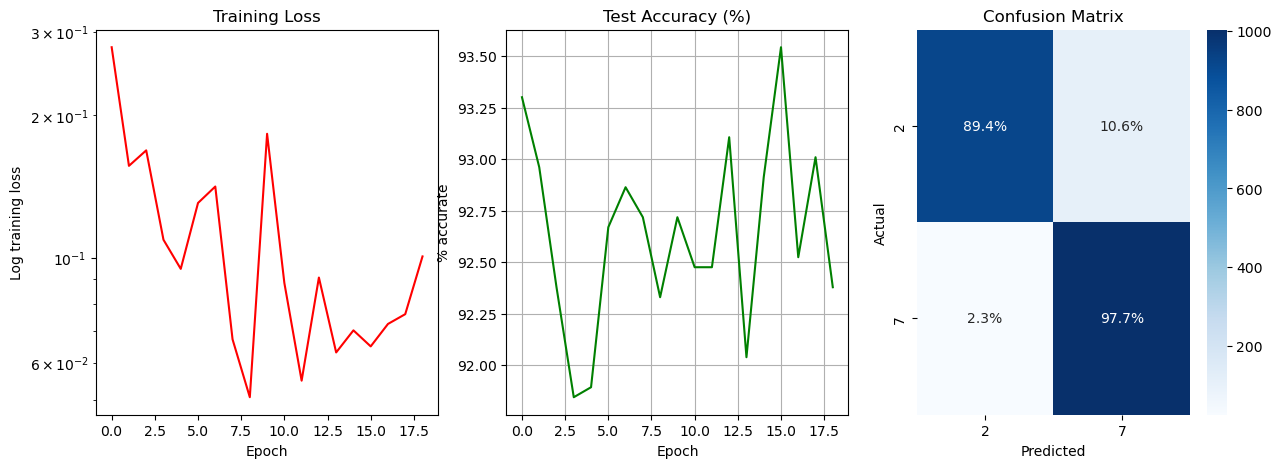

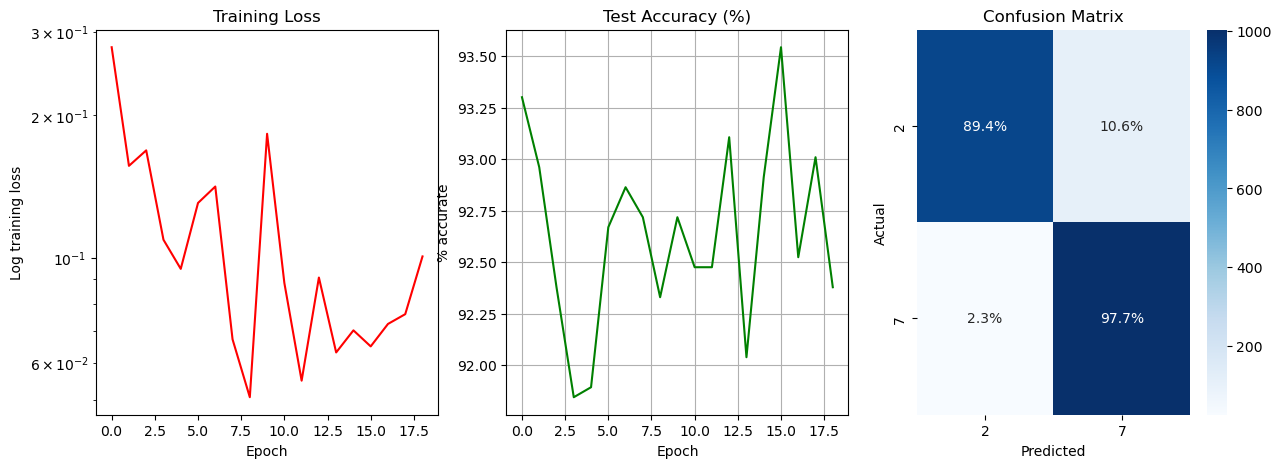

In [45]:
# Calculate AUROC, f1, precision, recall
#f1, recall, precision, auroc = f1_score(targets, preds, average='macro'), sm.recall_score(targets, preds), sm.precision_score(targets, preds), sm.roc_auc_score(targets, preds)

#print(f'f1 score: {f1} \n recall: {recall} \n precision: {precision} \n Area under receiving operating characteristic: {auroc}')

vis(train_loss, test_accs, confusion_mtxes, configs['class_labels'], figsize=(15, 5))


Text(0.5, 1.0, 'SMOTED Dataset Composition')

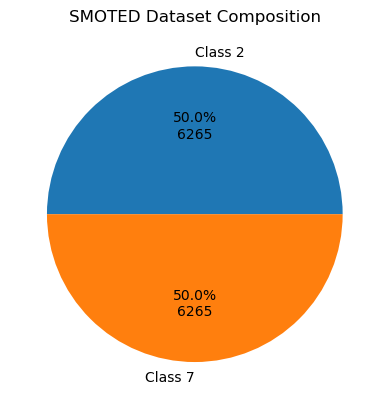

In [46]:
import seaborn as sns

#define data
__, data = torch.unique(train.targets, return_counts = True)
data
data.sum()
def fmt(x):
    return f'{x}%\n{int(x*data.sum()/100)}'

plt.pie(data, labels=['Class 2', 'Class 7'], autopct=fmt)
plt.title('SMOTED Dataset Composition')
